# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) December 2024

`HFSAnomalyModel` is like `HFSModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+0.g50000b9.dirty


## `get_molecule_data`

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

In [3]:
mol_data_12CN

{'freq': array([113123.3687, 113144.19  , 113170.535 , 113191.325 , 113488.142 ,
        113490.985 , 113499.643 , 113508.934 , 113520.4215]),
 'Aul': array([1.26969616e-06, 1.03939111e-05, 5.07869910e-06, 6.59525390e-06,
        6.64784064e-06, 1.17706070e-05, 1.04919208e-05, 5.12459350e-06,
        1.28243028e-06]),
 'degu': array([2, 2, 4, 4, 4, 6, 2, 4, 2]),
 'Eu': array([7.49702428e-16, 7.49701340e-16, 7.50014955e-16, 7.50013660e-16,
        7.52119441e-16, 7.51999228e-16, 7.52195648e-16, 7.52118159e-16,
        7.52194276e-16]),
 'relative_int': array([0.01204699, 0.09860036, 0.09633376, 0.1250773 , 0.12574146,
        0.33394774, 0.09921527, 0.09691221, 0.01212491]),
 'log10_Q_terms': array([0.40307694, 0.97433601])}

## Simulating Data

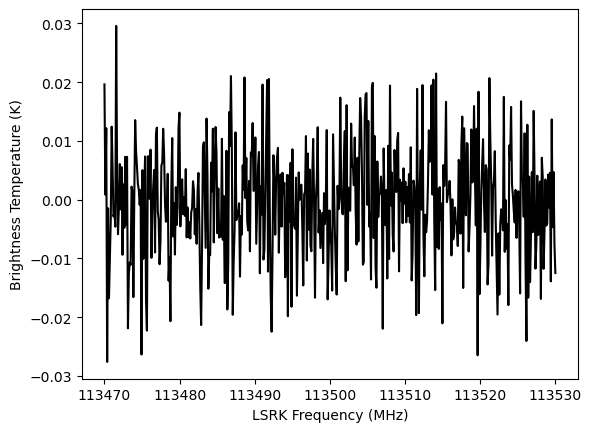

In [4]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Dropping the un-observed transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]


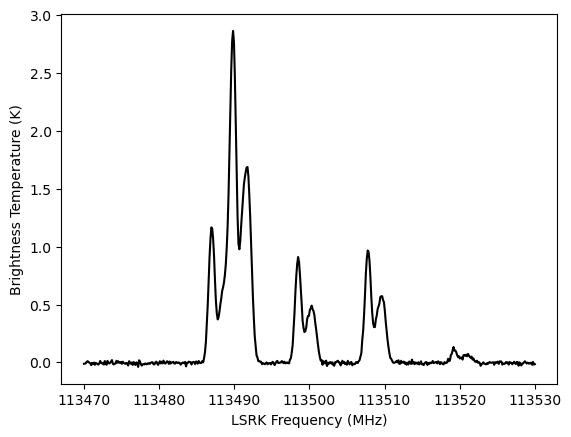

In [5]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSAnomalyModel(
    dummy_data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_tex_anomaly = 0.1, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

log10_tex = np.array([1.0, 1.2, 1.1])
log10_tex_comp = np.ones((len(model.mol_data['freq']), n_clouds))
for i, freq in enumerate(model.mol_data['freq']):
    if freq == 113499.643:
        log10_tex_comp[i] = np.array([0.8, 0.9, 1.0])
    elif freq == 113508.934:
        log10_tex_comp[i] = np.array([1.2, 1.4, 1.3])
    else:
        log10_tex_comp[i] = log10_tex

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_tex": log10_tex,
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "log10_tex_comp": log10_tex_comp,
    "baseline_observation_norm": [-0.5], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [7]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_data=mol_data_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_tex_anomaly = 0.1, # width of the hyperfine anomaly prior (K)
)
model.add_likelihood()

Dropping the un-observed transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]


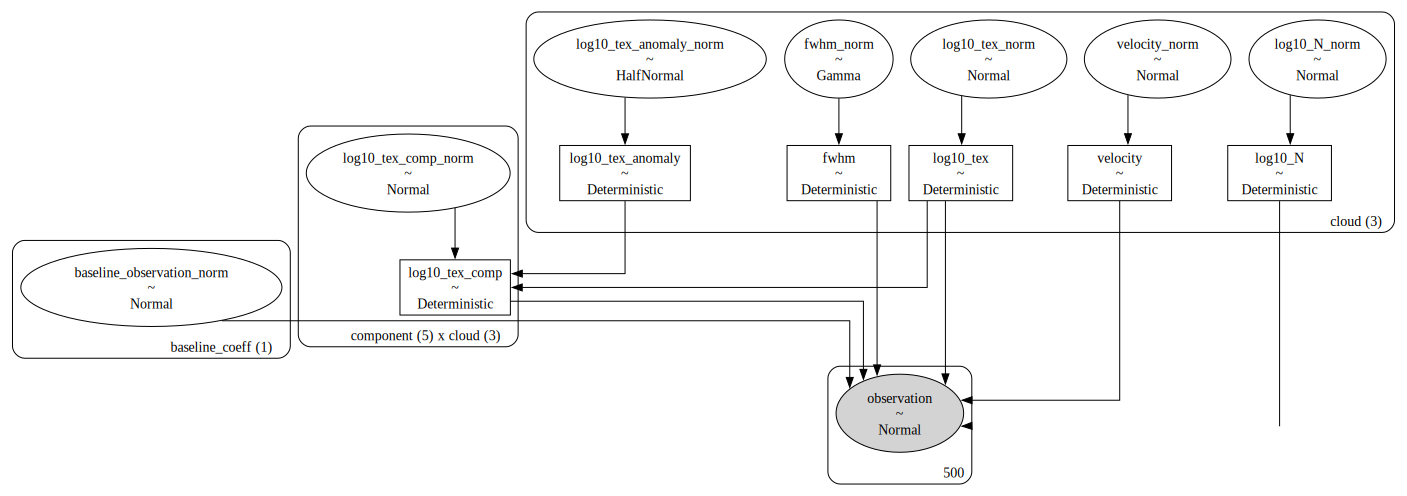

In [8]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, 1)
             log10_N_norm ~ Normal(0, 1)
           log10_tex_norm ~ Normal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
   log10_tex_anomaly_norm ~ HalfNormal(0, 1)
      log10_tex_comp_norm ~ Normal(0, 1)
                  log10_N ~ Deterministic(f(log10_N_norm))
                log10_tex ~ Deterministic(f(log10_tex_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
        log10_tex_anomaly ~ Deterministic(f(log10_tex_anomaly_norm))
           log10_tex_comp ~ Deterministic(f(log10_tex_comp_norm, log10_tex_anomaly_norm, log10_tex_norm))
              observation ~ Normal(f(baseline_observation_norm, log10_tex_comp_norm, log10_N_norm, log10_tex_anomaly_norm, log10_tex_norm, fwhm_norm, velocity_norm), <constant>)


Sampling: [baseline_observation_norm, fwhm_norm, log10_N_norm, log10_tex_anomaly_norm, log10_tex_comp_norm, log10_tex_norm, observation, velocity_norm]


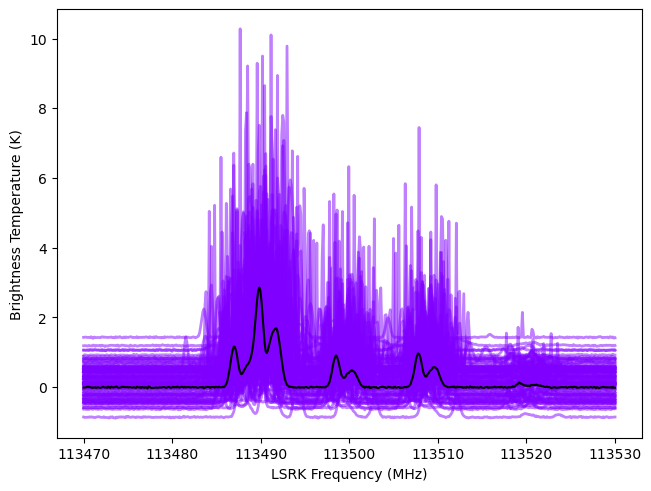

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [11]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 74,953


Output()

Runtime: 1.48 minutes


In [12]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.794,0.002,13.789,13.798,0.000,0.000,1041.0,948.0,NaN
log10_N[1],13.965,0.001,13.963,13.968,0.000,0.000,1112.0,981.0,NaN
log10_N[2],14.096,0.001,14.094,14.098,0.000,0.000,1125.0,975.0,NaN
log10_tex[0],1.061,0.010,1.042,1.080,0.000,0.000,969.0,940.0,NaN
log10_tex[1],0.911,0.008,0.898,0.926,0.000,0.000,1076.0,950.0,NaN
log10_tex[2],0.953,0.007,0.941,0.965,0.000,0.000,979.0,1112.0,NaN
fwhm[0],5.152,0.041,5.083,5.235,0.001,0.001,884.0,948.0,NaN
fwhm[1],3.211,0.010,3.191,3.229,0.000,0.000,774.0,875.0,NaN
fwhm[2],2.266,0.005,2.255,2.275,0.000,0.000,928.0,983.0,NaN
velocity[0],0.607,0.020,0.569,0.643,0.001,0.000,1009.0,942.0,NaN


Sampling: [observation]


Output()

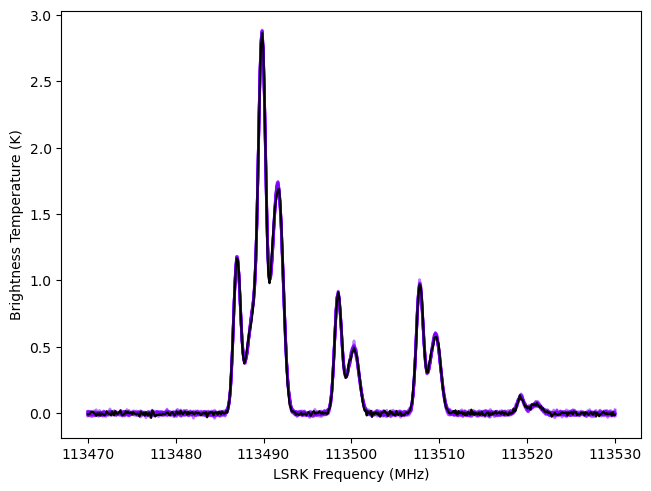

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [14]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 74,953
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, log10_tex_anomaly_norm, log10_tex_comp_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1530 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
Runtime: 26.51 minutes


In [15]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [22]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.432,0.001,-0.434,-0.430,0.000,0.000,11094.0,5892.0,1.0
log10_N_norm[0],-2.704,0.236,-3.157,-2.264,0.004,0.003,3480.0,4742.0,1.0
log10_N_norm[1],-0.037,0.124,-0.260,0.203,0.002,0.001,3609.0,3967.0,1.0
log10_N_norm[2],0.913,0.109,0.721,1.134,0.002,0.001,4050.0,4376.0,1.0
log10_tex_norm[0],-0.409,0.969,-2.216,1.360,0.013,0.010,5445.0,5623.0,1.0
log10_tex_norm[1],-0.166,0.602,-1.250,1.002,0.009,0.007,4161.0,4823.0,1.0
log10_tex_norm[2],0.384,0.538,-0.626,1.407,0.008,0.006,4482.0,4967.0,1.0
velocity_norm[0],-0.010,0.008,-0.027,0.005,0.000,0.000,3582.0,4227.0,1.0
velocity_norm[1],-0.405,0.006,-0.417,-0.393,0.000,0.000,3755.0,4488.0,1.0
velocity_norm[2],0.599,0.001,0.598,0.601,0.000,0.000,8158.0,6124.0,1.0


Sampling: [observation]


Output()

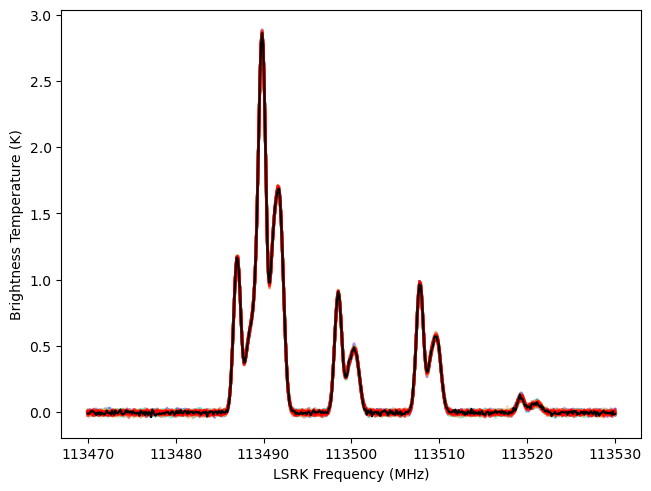

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

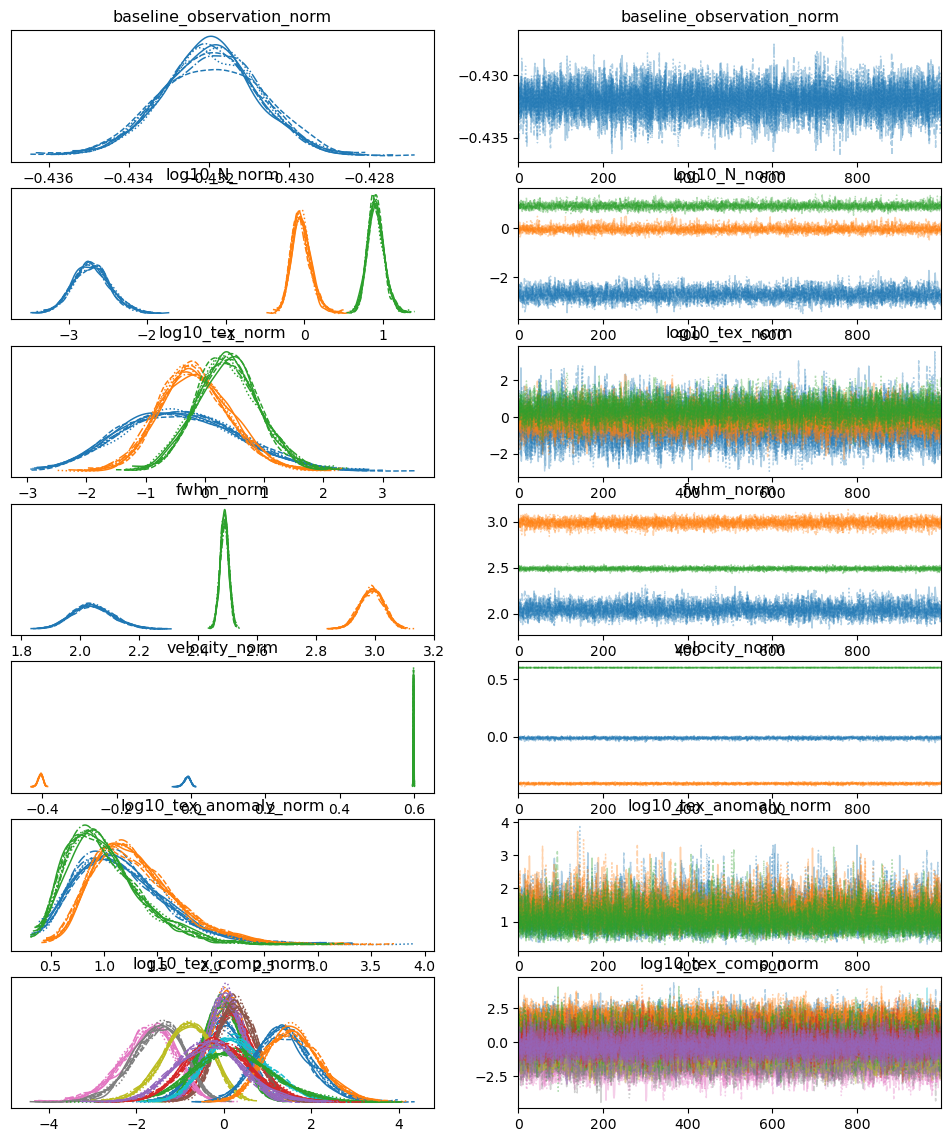

In [18]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

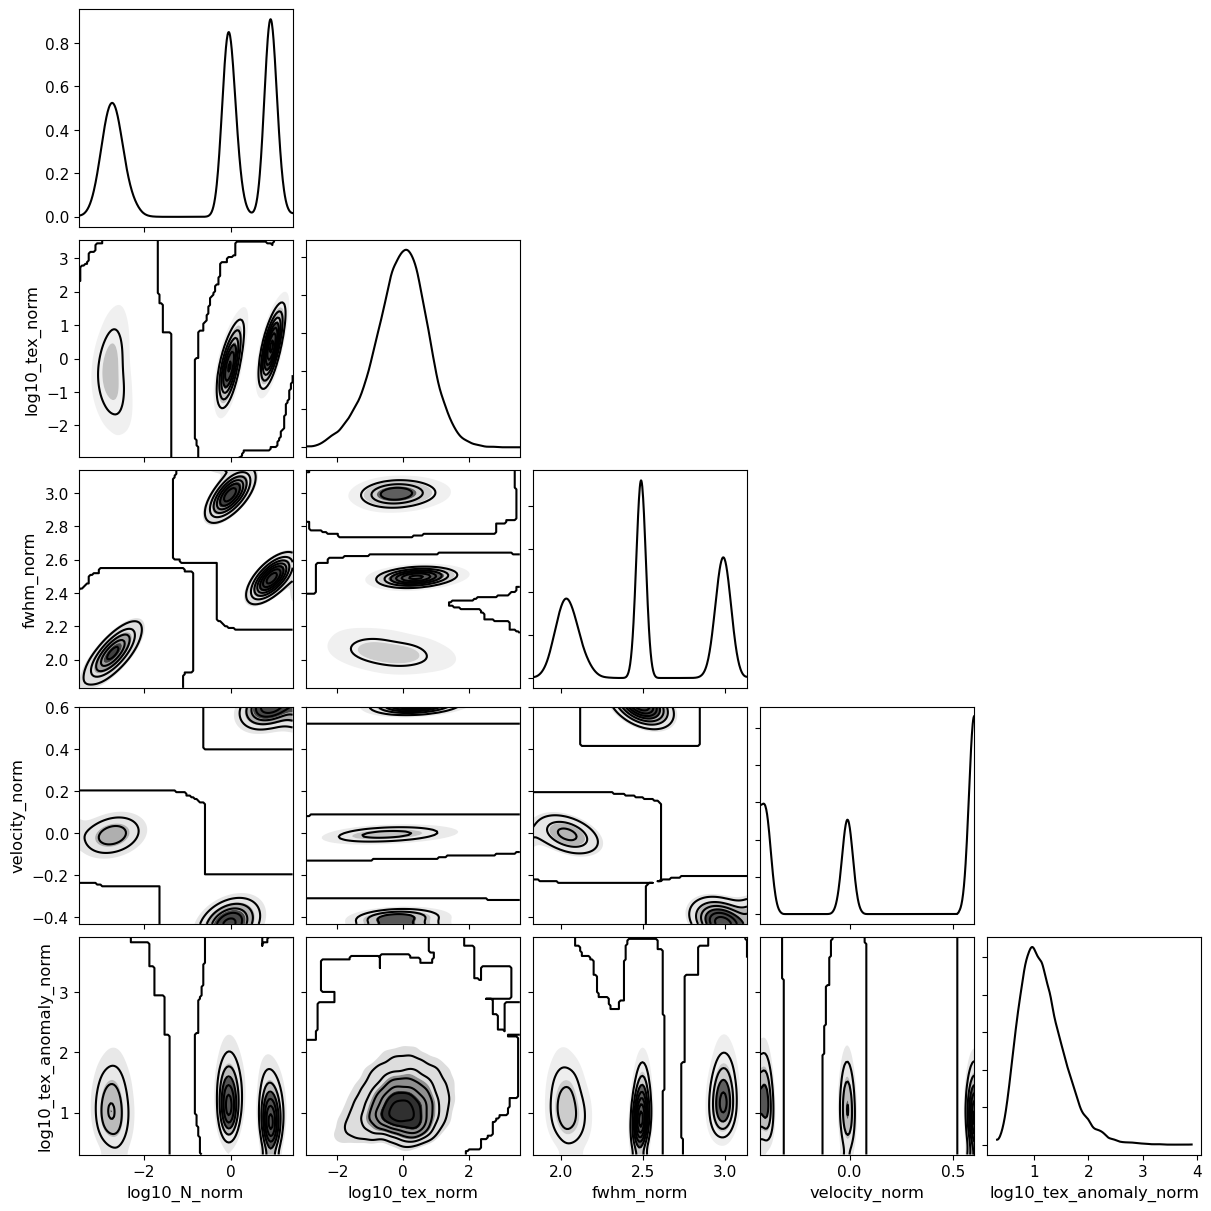

In [19]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_freeRVs if "log10_tex_comp" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

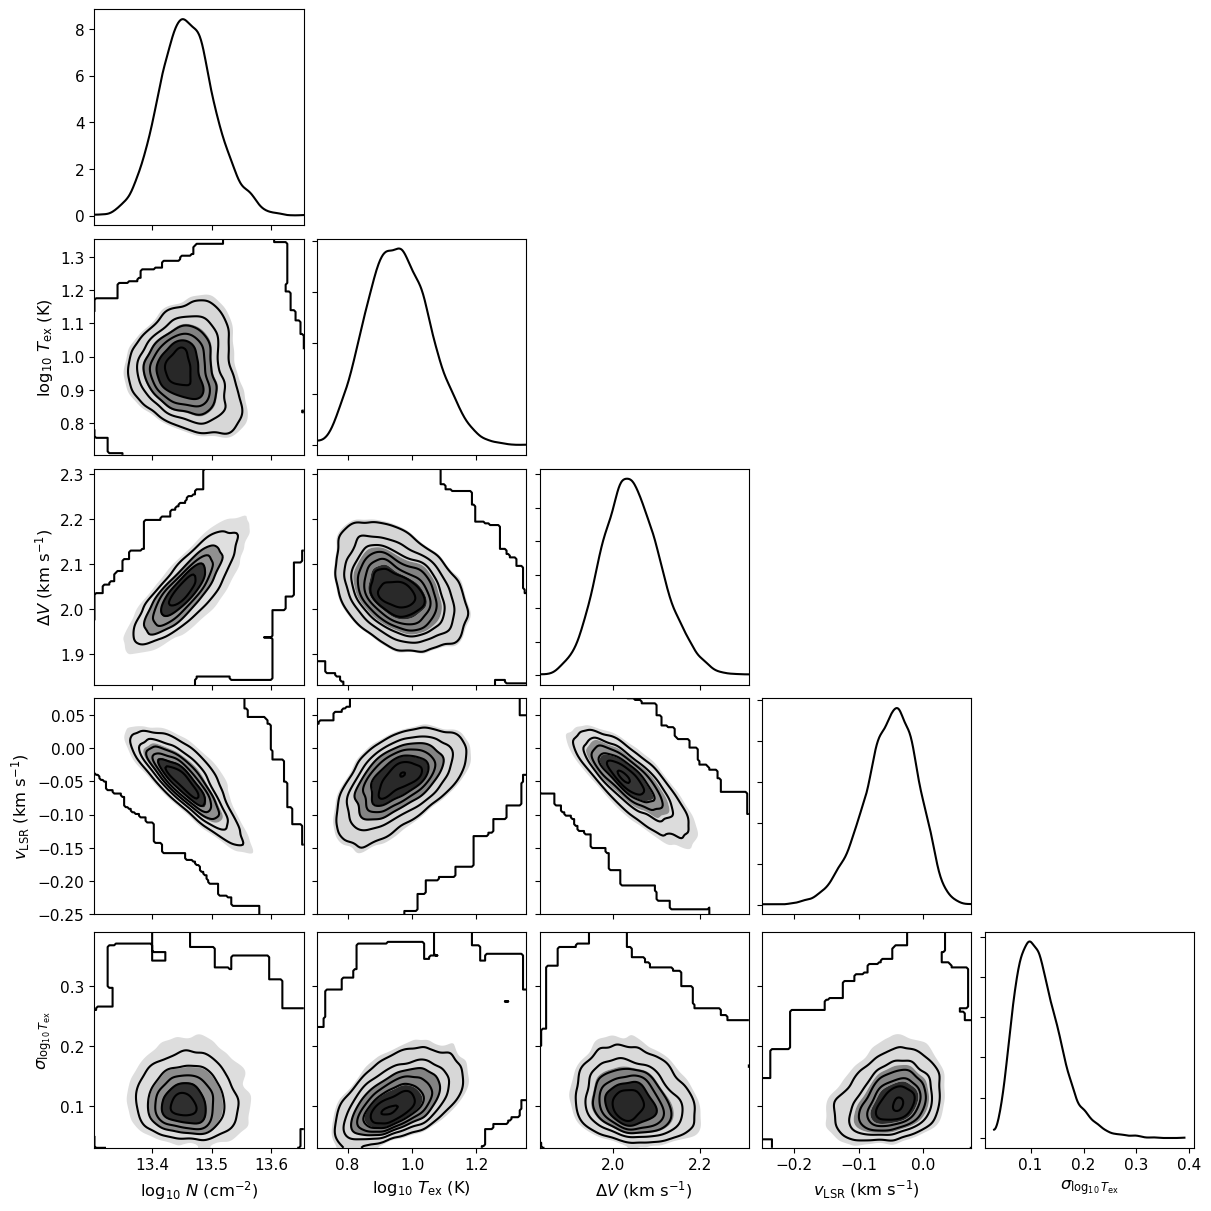

In [20]:
var_names = [param for param in model.cloud_deterministics if "log10_tex_comp" not in param]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [21]:
point_stats = az.summary(model.trace.solution_0, model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -2973.01946088256


,mean,sd,hdi_16%,hdi_84%
log10_N[0],13.459,0.047,13.412,13.503
log10_N[1],13.993,0.025,13.964,14.011
log10_N[2],14.183,0.022,14.161,14.203
log10_tex[0],0.959,0.097,0.849,1.044
log10_tex[1],0.983,0.060,0.913,1.029
log10_tex[2],1.038,0.054,0.986,1.090
fwhm[0],2.043,0.068,1.973,2.107
fwhm[1],2.989,0.040,2.948,3.027
fwhm[2],2.490,0.015,2.476,2.504
velocity[0],-0.052,0.042,-0.084,-0.002
